In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
42644,NaN,NaN,International,2020-09-07,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42645,NaN,NaN,International,2020-09-08,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42646,NaN,NaN,International,2020-09-09,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


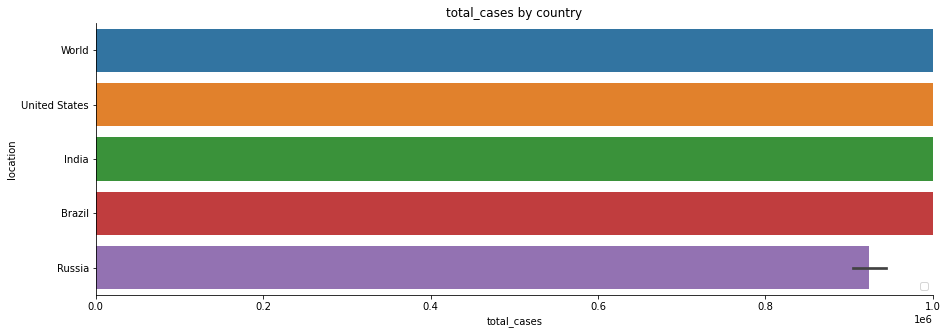

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


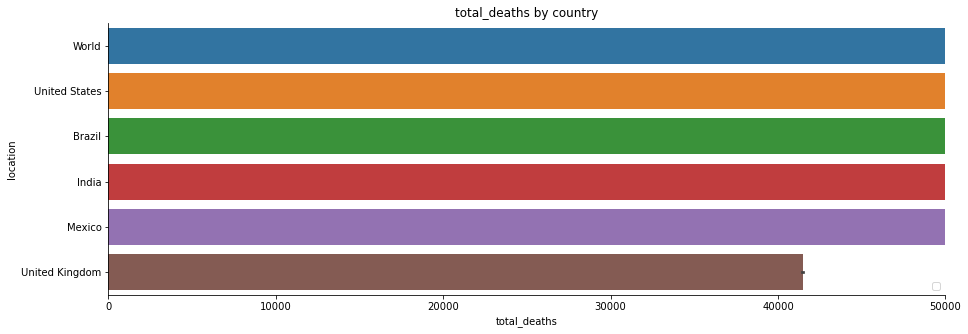

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


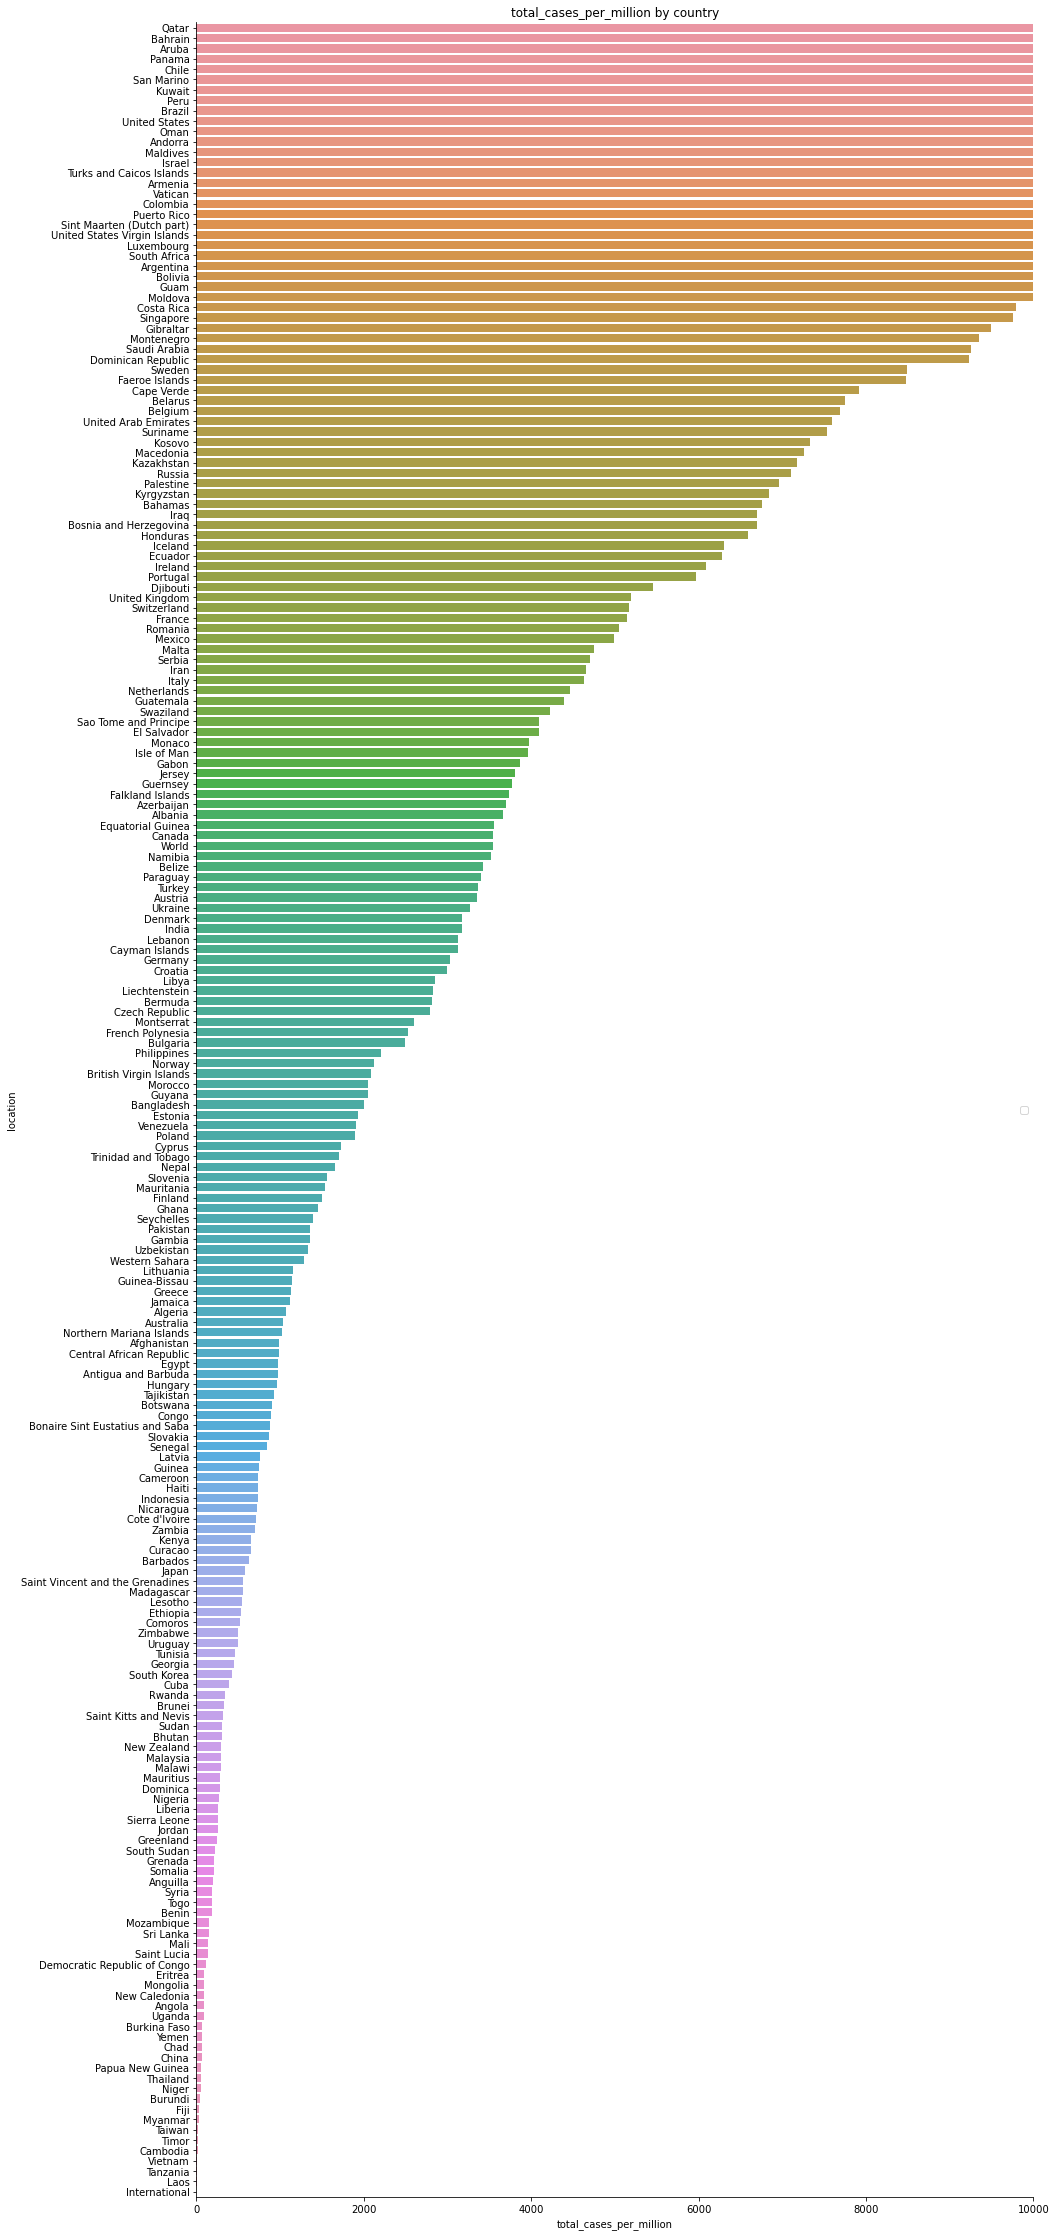

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


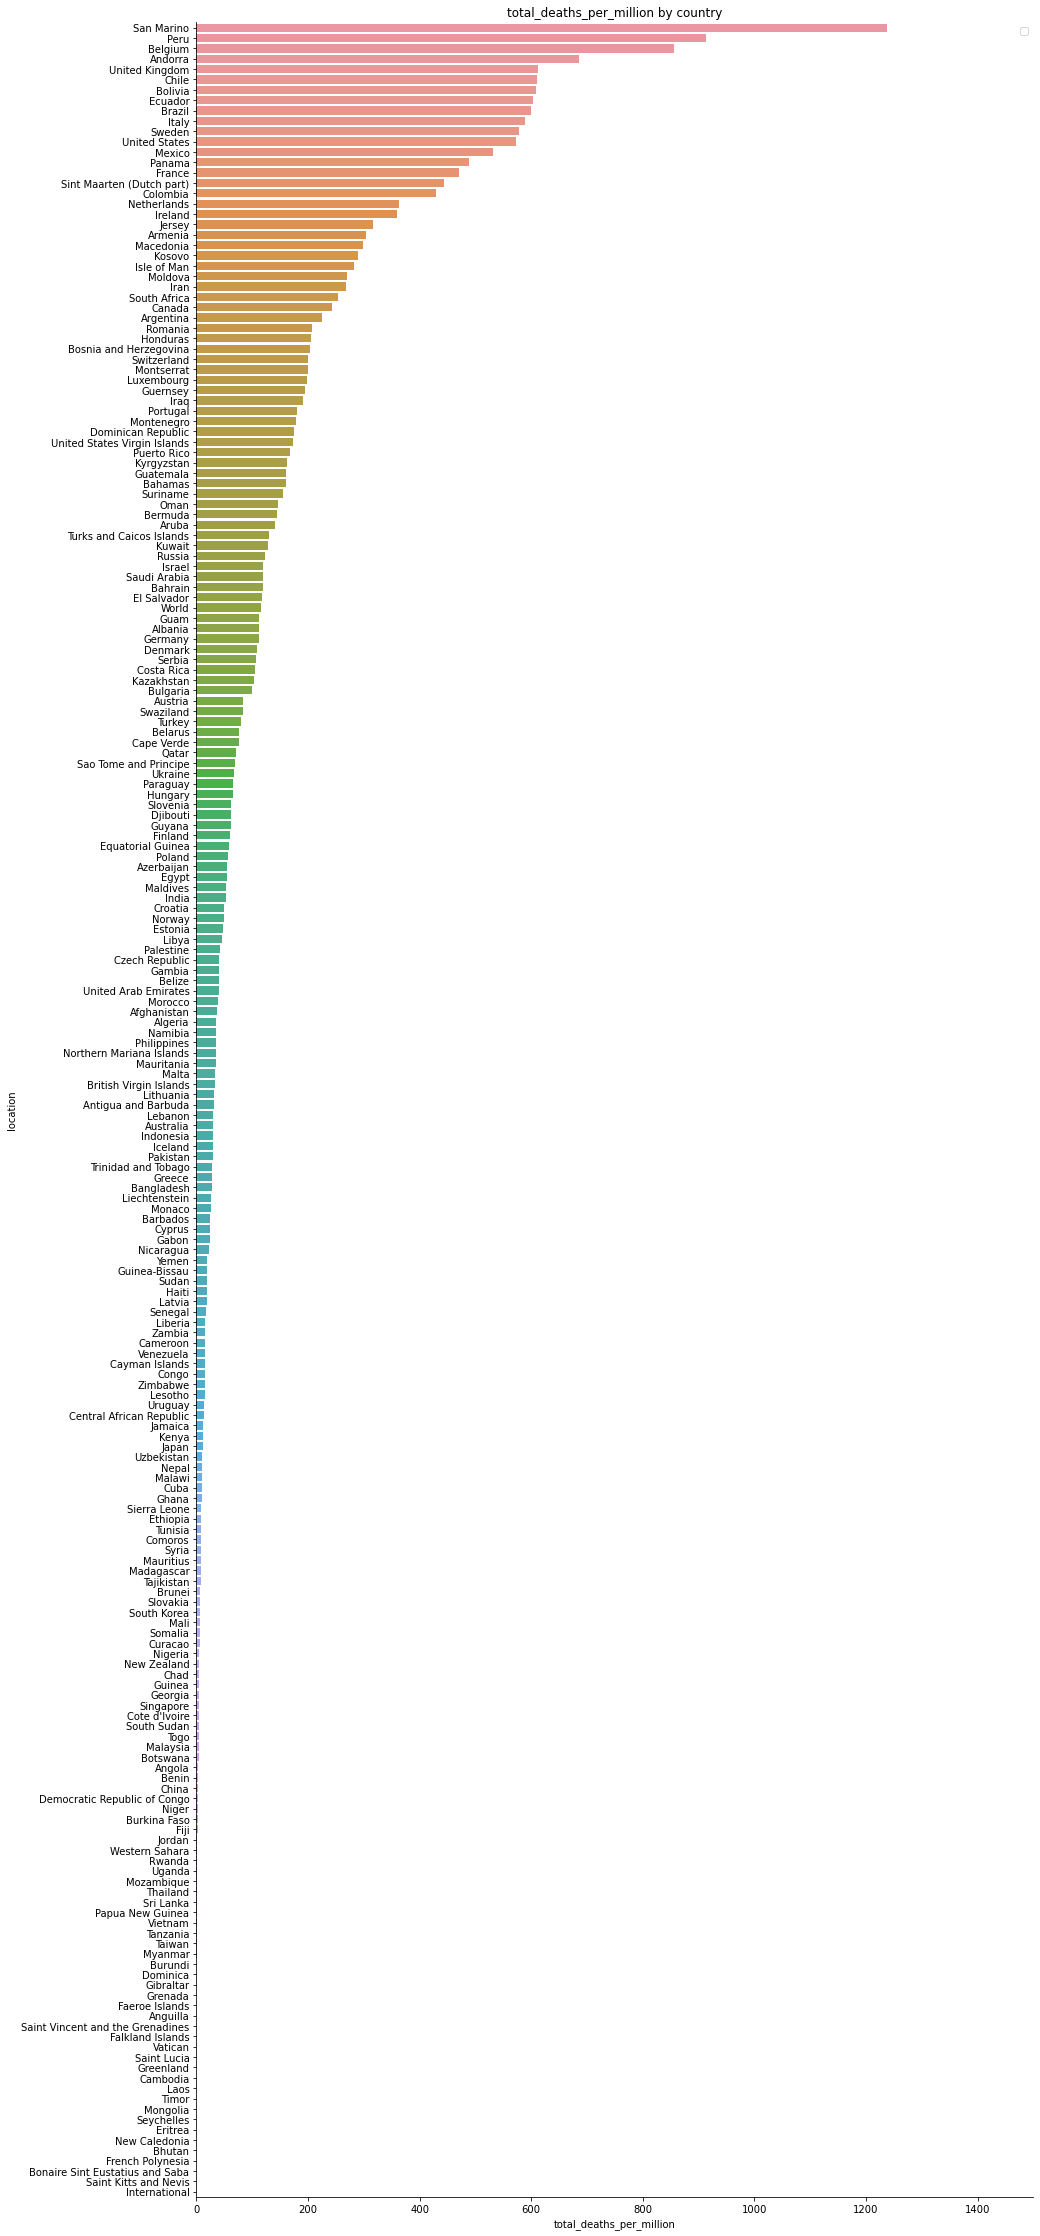

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

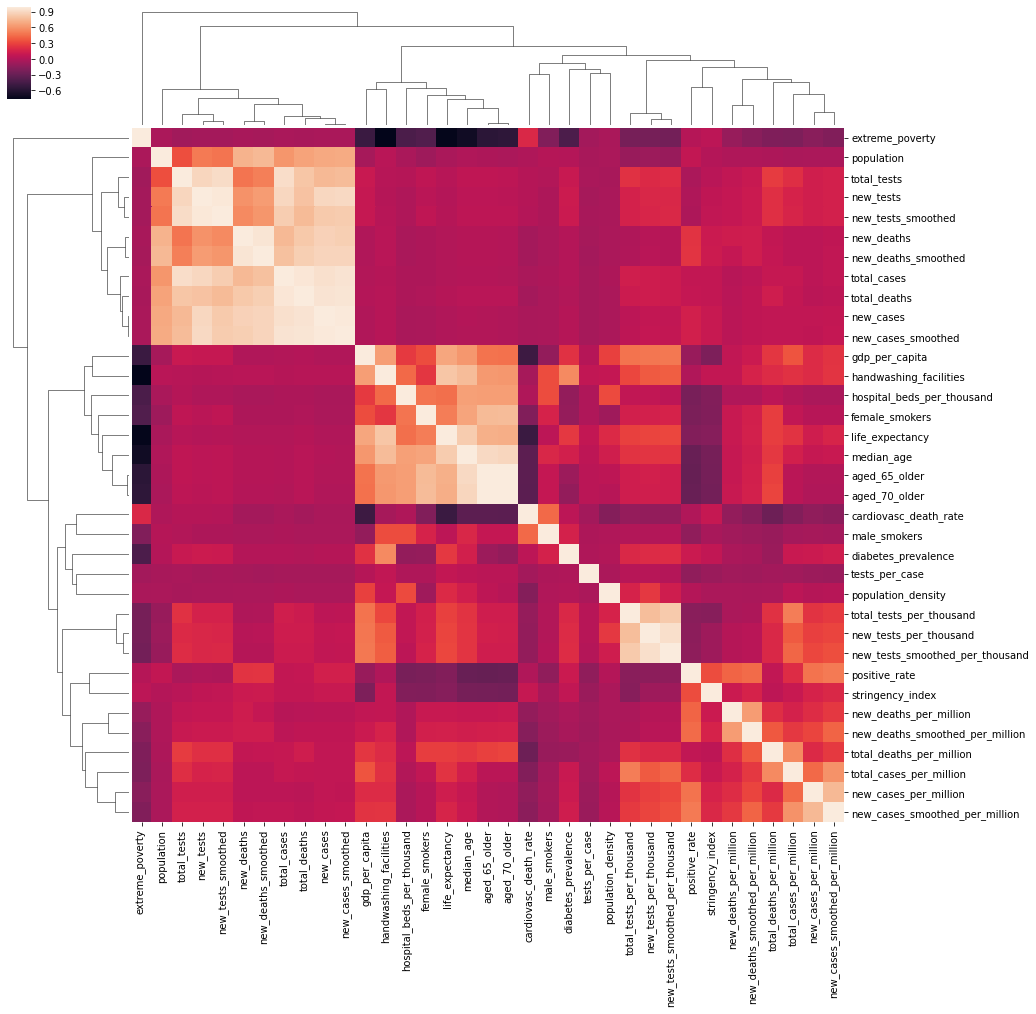

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9990779756421255 (+/- 0.0010383282801405124)
Coef :  [1.03460418e+00 9.07317119e-05 9.64541359e-05]
3 Last_days :  [[27170044 27375983 27609408]]
Today :  27609408
Prediction + :  598111
Tomorow :  28207519
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996267030804247 (+/- 0.00011101034426243855)
Coef :  [0.12600441 0.42788891 0.45643368]
3 Last_days :  [[889339 893161 898088]]
Today :  898088
Prediction + :  8946
Tomorow :  907034
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.895221557714069 (+/- 0.14271782779208012)
Coef :  [-0.7354168   0.78007669  0.95839292]
3 Last_days :  [[324777 328980 335524]]
Today :  335524
Prediction + :  3937
Tomorow :  339461
                                     
--------- Total Death -----------------
                                     
R^2: 0.9548849797326864 (+/- 0.05405930512324884)
Coef :  [-0.75026017  0.78870013  0.96055679]
3 Last_days :  [[30701 30726 30764]]
Today :  30764
Prediction + :  39
Tomorow :  30803
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.944371001759488 (+/- 0.04462990363113163)
Coef :  [-0.32698708 -0.01566306  1.3369155 ]
3 Last_days :  [[90058 90079 90087]]
Today :  90087
Prediction + :  21
Tomorow :  90108
                                     
--------- Total Death -----------------
                                     
R^2: -108.69451072939547 (+/- 155.01769113304465)
Coef :  [-0.07724131  0.01245818  1.05661274]
3 Last_days :  [[4730 4732 4733]]
Today :  4733
Prediction + :  6
Tomorow :  4739
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9752876706799589 (+/- 0.03377124844774206)
Coef :  [-0.8216145   0.8971175   0.92382848]
3 Last_days :  [[277634 278784 280153]]
Today :  280153
Prediction + :  1045
Tomorow :  281198
                                     
--------- Total Death -----------------
                                     
R^2: 0.7995957754532713 (+/- 0.25759003206389014)
Coef :  [-0.82531448  0.89801527  0.92636786]
3 Last_days :  [[35541 35553 35563]]
Today :  35563
Prediction + :  30
Tomorow :  35593
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6323603980596323 (+/- 0.50992594557651)
Coef :  [-0.40116683  0.22249605  1.18322112]
3 Last_days :  [[498989 525549 534513]]
Today :  534513
Prediction + :  14861
Tomorow :  549374
                                     
--------- Total Death -----------------
                                     
R^2: -0.006801860848832275 (+/- 1.1426064627539976)
Coef :  [-0.72720686  0.63244437  1.09378297]
3 Last_days :  [[29418 29516 29594]]
Today :  29594
Prediction + :  87
Tomorow :  29681
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9872331977939459 (+/- 0.017470332905401065)
Coef :  [0.07782707 0.46112717 0.47506764]
3 Last_days :  [[6276421 6300671 6327793]]
Today :  6327793
Prediction + :  87673
Tomorow :  6415466
                                     
--------- Total Death -----------------
                                     
R^2: 0.998604963774735 (+/- 0.0004920677297827282)
Coef :  [-0.48562021  0.70691745  0.78127978]
3 Last_days :  [[188941 189208 189679]]
Today :  189679
Prediction + :  885
Tomorow :  190564
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.97892895036774 (+/- 0.028817693018834648)
Coef :  [-0.70419098  0.83959469  0.86497772]
3 Last_days :  [[347152 350100 352560]]
Today :  352560
Prediction + :  2436
Tomorow :  354996
                                     
--------- Total Death -----------------
                                     
R^2: 0.306785089991594 (+/- 0.9358685874921752)
Coef :  [-0.76895344  0.83117085  0.9371194 ]
3 Last_days :  [[41551 41554 41586]]
Today :  41586
Prediction + :  36
Tomorow :  41622
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9824430257229237 (+/- 0.023603303373894734)
Coef :  [-0.7895974   0.85428667  0.93506084]
3 Last_days :  [[250799 252298 253474]]
Today :  253474
Prediction + :  1360
Tomorow :  254834
                                     
--------- Total Death -----------------
                                     
R^2: 0.3167669153159203 (+/- 0.9552829862954483)
Coef :  [-0.78838917  0.84030837  0.94735356]
3 Last_days :  [[9325 9329 9338]]
Today :  9338
Prediction + :  9
Tomorow :  9347
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.788916957484621 (+/- 0.2967249055650187)
Coef :  [0.25269229 0.38004957 0.37806804]
3 Last_days :  [[386658 388810 391112]]
Today :  391112
Prediction + :  3698
Tomorow :  394810
                                     
--------- Total Death -----------------
                                     
R^2: 0.9673519824381037 (+/- 0.045585621157316354)
Coef :  [0.04327653 0.48816564 0.47966324]
3 Last_days :  [[22293 22410 22542]]
Today :  22542
Prediction + :  234
Tomorow :  22776
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9993171505118684 (+/- 0.0006574202718598069)
Coef :  [-0.70088882  0.83212654  0.86616946]
3 Last_days :  [[279806 281509 283270]]
Today :  283270
Prediction + :  1346
Tomorow :  284616
                                     
--------- Total Death -----------------
                                     
R^2: 0.9991628593572727 (+/- 0.0006446964934146687)
Coef :  [-0.81159114  0.89273107  0.91642252]
3 Last_days :  [[6673 6730 6782]]
Today :  6782
Prediction + :  46
Tomorow :  6828
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9831843686559325 (+/- 0.018861738187712394)
Coef :  [-0.15234061  0.50607328  0.66018805]
3 Last_days :  [[4137521 4147794 4162073]]
Today :  4162073
Prediction + :  61546
Tomorow :  4223619
                                     
--------- Total Death -----------------
                                     
R^2: 0.47106756070720807 (+/- 0.7429298908497858)
Coef :  [-0.09953659  0.51158577  0.59908879]
3 Last_days :  [[126650 126960 127464]]
Today :  127464
Prediction + :  1530
Tomorow :  128994
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(27609408, 898088, 28207519, 907034),
 (335524, 30764, 339461, 30803),
 (280153, 35563, 281198, 35593),
 (534513, 29594, 549374, 29681),
 (6327793, 189679, 6415466, 190564),
 (90087, 4733, 90108, 4739),
 (352560, 41586, 354996, 41622),
 (253474, 9338, 254834, 9347),
 (391112, 22542, 394810, 22776),
 (283270, 6782, 284616, 6828),
 (4162073, 127464, 4223619, 128994)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-09,France,339461.0,0.0,30803.0,0.0,0.0,0.0
0,2020-09-09,China,90108.0,0.0,4739.0,0.0,0.0,0.0
0,2020-09-09,Italy,281198.0,0.0,35593.0,0.0,0.0,0.0
0,2020-09-09,Spain,549374.0,0.0,29681.0,0.0,0.0,0.0
0,2020-09-09,United States,6415466.0,0.0,190564.0,0.0,0.0,0.0
0,2020-09-09,World,28207519.0,0.0,907034.0,0.0,0.0,0.0
0,2020-09-09,United Kingdom,354996.0,0.0,41622.0,0.0,0.0,0.0
0,2020-09-09,Germany,254834.0,0.0,9347.0,0.0,0.0,0.0
0,2020-09-09,Iran,394810.0,0.0,22776.0,0.0,0.0,0.0
0,2020-09-09,Turkey,284616.0,0.0,6828.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")